In [44]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import math
from tqdm import tqdm
from scipy.optimize import minimize, rosen
from joblib import Parallel, delayed

Loading Data

In [3]:
# Data for Flight 1 and Drone 1
f=1  #Flight no. - 1-9
d=1  # Drone no. - For single drone data 1-6, for stitched data "All"
path='D:\RA\Milan Dataset\Repo Upload'
data_1=pd.read_csv(f'{path}/Data_T{f}/T{f}_D{d}.csv')

In [4]:
# Data for All Drones stitched data
f=1  #Flight no. - 1-9
d='All'
data_all=pd.read_csv(f'{path}/Data_T{f}/T{f}_D{d}.csv')

In [5]:
data_all.head()

,Vehicle_ID,Vehicle_type,Time [s],x [m],y [m],Speed [km/h],Lon. Acc. [ms-2],Lat. Acc. [ms-2],Angle [rad],Vehicle_length [m],Vehicle_width [m],Lane,Leader_ID,Follower_ID,Left_Leader_ID,Left_Follower_ID,Right_Leader_ID,Right_Follower_ID
0,1.0,Medium Vehicle,0.000000,511822.27,5026491.01,57.8808,-0.2495,-0.0869,5.7584,5.8333,2.6667,10,-1,-1,-1,-1,-1,-1
1,1.0,Medium Vehicle,0.033367,511822.74,5026490.74,57.8496,-0.2707,-0.1035,5.7584,5.8333,2.6667,10,-1,-1,-1,-1,-1,-1
2,1.0,Medium Vehicle,0.066733,511823.20,5026490.47,57.8154,-0.2991,-0.1153,5.7585,5.8333,2.6667,10,-1,-1,-1,-1,-1,-1
3,1.0,Medium Vehicle,0.100100,511823.67,5026490.20,57.7784,-0.3162,-0.1222,5.7585,5.8333,2.6667,10,-1,-1,-1,-1,-1,-1
4,1.0,Medium Vehicle,0.133467,511824.13,5026489.93,57.7401,-0.3222,-0.1243,5.7585,5.8333,2.6667,10,-1,-1,-1,-1,-1,-1


Top view plot

In [6]:
def top_view_plot(data,d,f):
    fig,ax=plt.subplots(figsize=(30,8))
    p=plt.scatter(data['x [m]'],data['y [m]'],c=data['Speed [km/h]'],cmap='viridis',s=0.1,vmax=100, vmin=0, alpha=0.7)
    plt.xlabel('X Position (m)', fontsize=18)
    plt.ylabel('Y Position (m)', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    cbar = plt.colorbar(p, ax=ax)
    cbar.set_label('Speed (km/h)', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(f'Top View Plot [Drone:{d}]', fontsize=18)
    plt.show()
    #plt.savefig('TopPlot_T1_AllD.png', bbox_inches="tight")

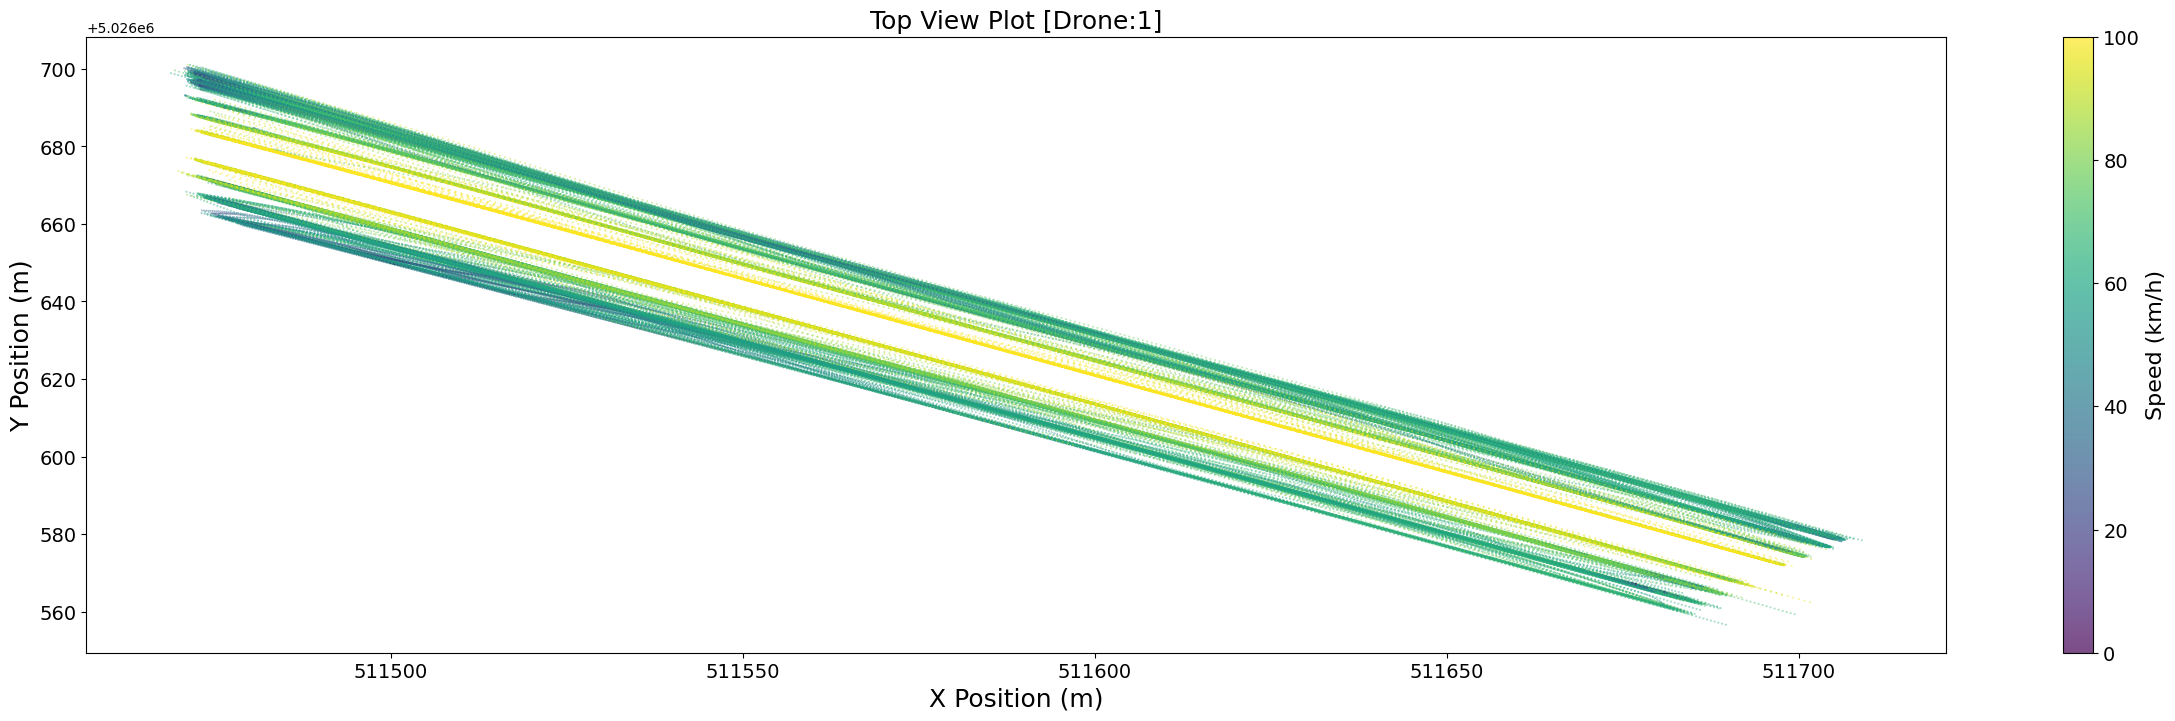

In [7]:
top_view_plot(data_1,1,1)

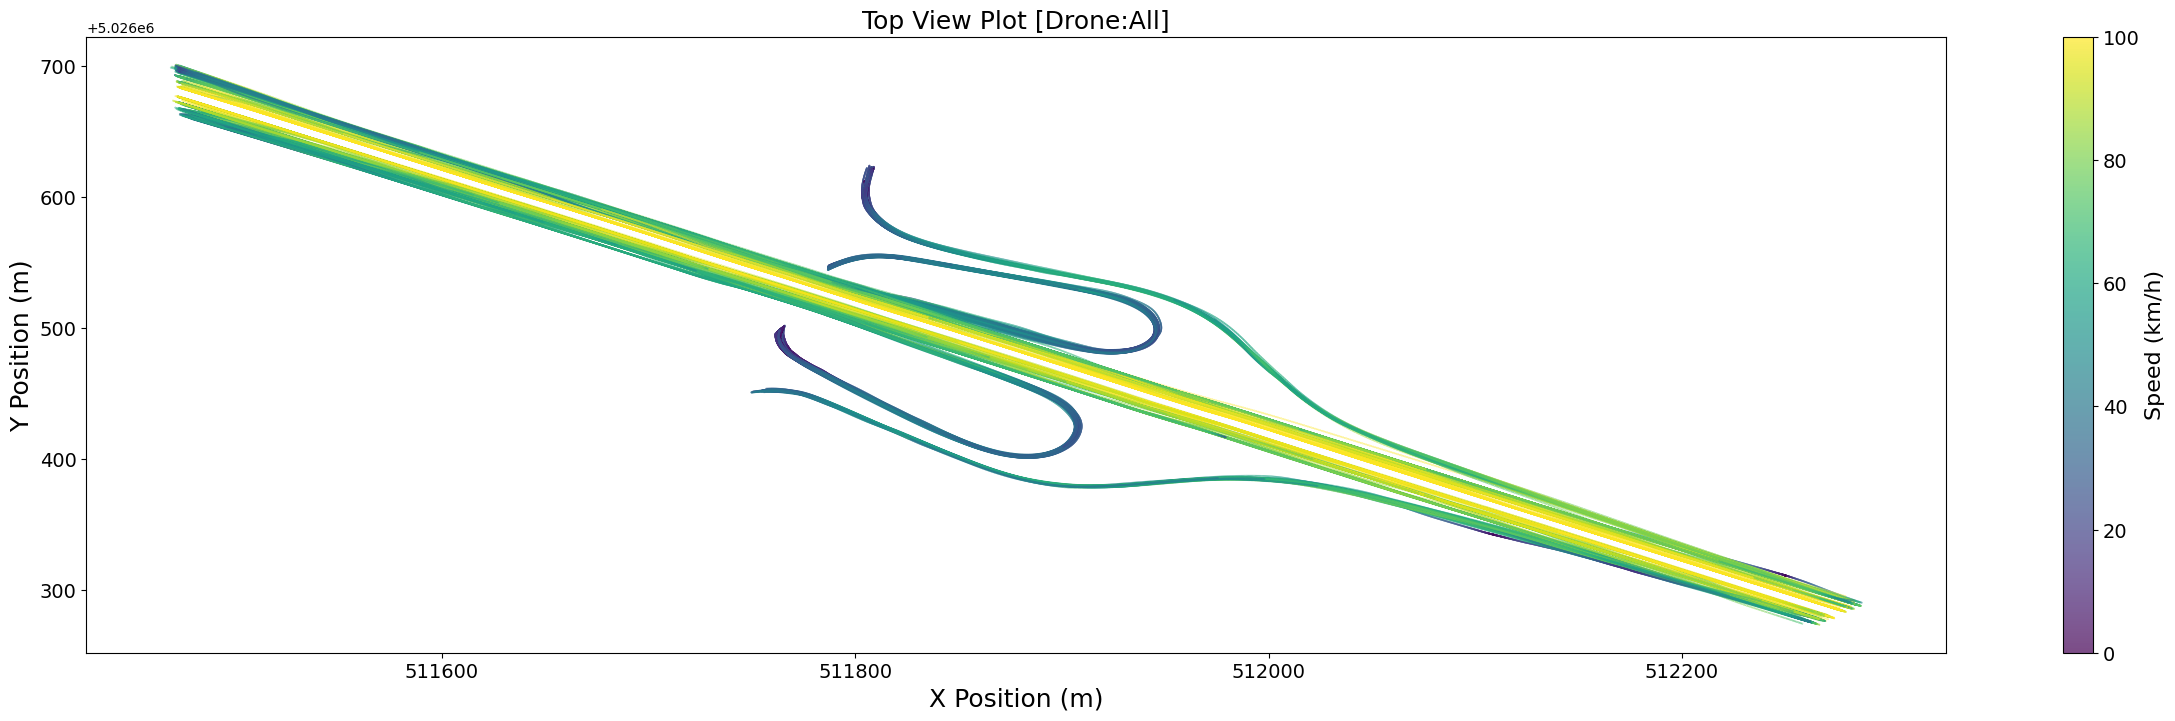

In [8]:
top_view_plot(data_all,'All',1)

# Rotation of coordinates so that major road is parallel to X-axis

In [9]:
def angle_of_dataset(data):
    """
    Finds the vehicle ID that traveled the maximum distance and fits a linear model
    to its trajectory data (x[m] vs. y[m]), then calculates the angle of the trajectory.

    Parameters:
        data (pd.DataFrame): Dataframe containing trajectory data with columns 'Vehicle_ID', 'x [m]', and 'y [m]'.

    Returns:
        Angle of trajectory in degrees
    """
    # Calculate distance traveled for each vehicle
    distance_traveled = data.groupby('Vehicle_ID')['x [m]'].agg(lambda x: x.max() - x.min())

    # Find the Vehicle_ID with the maximum distance traveled
    max_distance_vehicle_id = distance_traveled.idxmax()

    # Extract data for the vehicle with the maximum distance traveled
    vehicle_data = data[data['Vehicle_ID'] == max_distance_vehicle_id]

    # Fit a linear regression model to the (x, y) coordinates
    X = vehicle_data[['x [m]']].values  # Predictor variable (x)
    Y = vehicle_data[['y [m]']].values  # Response variable (y)

    model = LinearRegression()
    model.fit(X, Y)

    # Compute the angle of the fitted line in degrees
    slope = model.coef_[0][0]
    angle_degrees = np.arctan(slope) * (180 / np.pi)

    return angle_degrees



In [10]:
data=data_1.copy()
distance_traveled = data.groupby('Vehicle_ID')['x [m]'].agg(lambda x: x.max() - x.min())

In [11]:
top10_indices=np.argsort(np.array(distance_traveled))[::-1][:10]
top10_values = np.array(distance_traveled)[top10_indices]
top10_indices

array([1259, 1265,  326,  266,  691, 1105,  262,  709,  318,  441],
      dtype=int64)

In [12]:
angle_of_dataset(data_1)

-26.926241028751804

In [13]:
angle_of_dataset(data_all)

-26.71637355090493

Rotating the coordinates

In [14]:
def data_rotate (data, x_shift=0, y_shift=0, units="DEGREES"):

    # Shift to origin (0,0)
    x=data['x [m]']
    y=data['y [m]']
    x = x - x_shift
    y = y - y_shift

    angle= angle_of_dataset(data)*(-1)
    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift
    data['x_rot'],data['y_rot'] = xr,yr
    return data

In [19]:
data_1_rotate=data_rotate(data_1)
data_all_rotate=data_rotate(data_all)

# Plotting Rotated Data

In [20]:
def top_view_plot_rotate(data,d,f):
    fig,ax=plt.subplots(figsize=(30,8))
    p=plt.scatter(data['x_rot']-data['x_rot'].min(),data['y_rot']-data['y_rot'].min(),c=data['Speed [km/h]'],cmap='viridis',s=0.1,vmax=100, vmin=0, alpha=0.7)
    plt.xlabel('X Position (m)', fontsize=18)
    plt.ylabel('Y Position (m)', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    cbar = plt.colorbar(p, ax=ax)
    cbar.set_label('Speed (km/h)', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(f'Top View Plot [Drone:{d}]', fontsize=18)
    plt.show()
    #plt.savefig('TopPlot_T1_AllD.png', bbox_inches="tight")

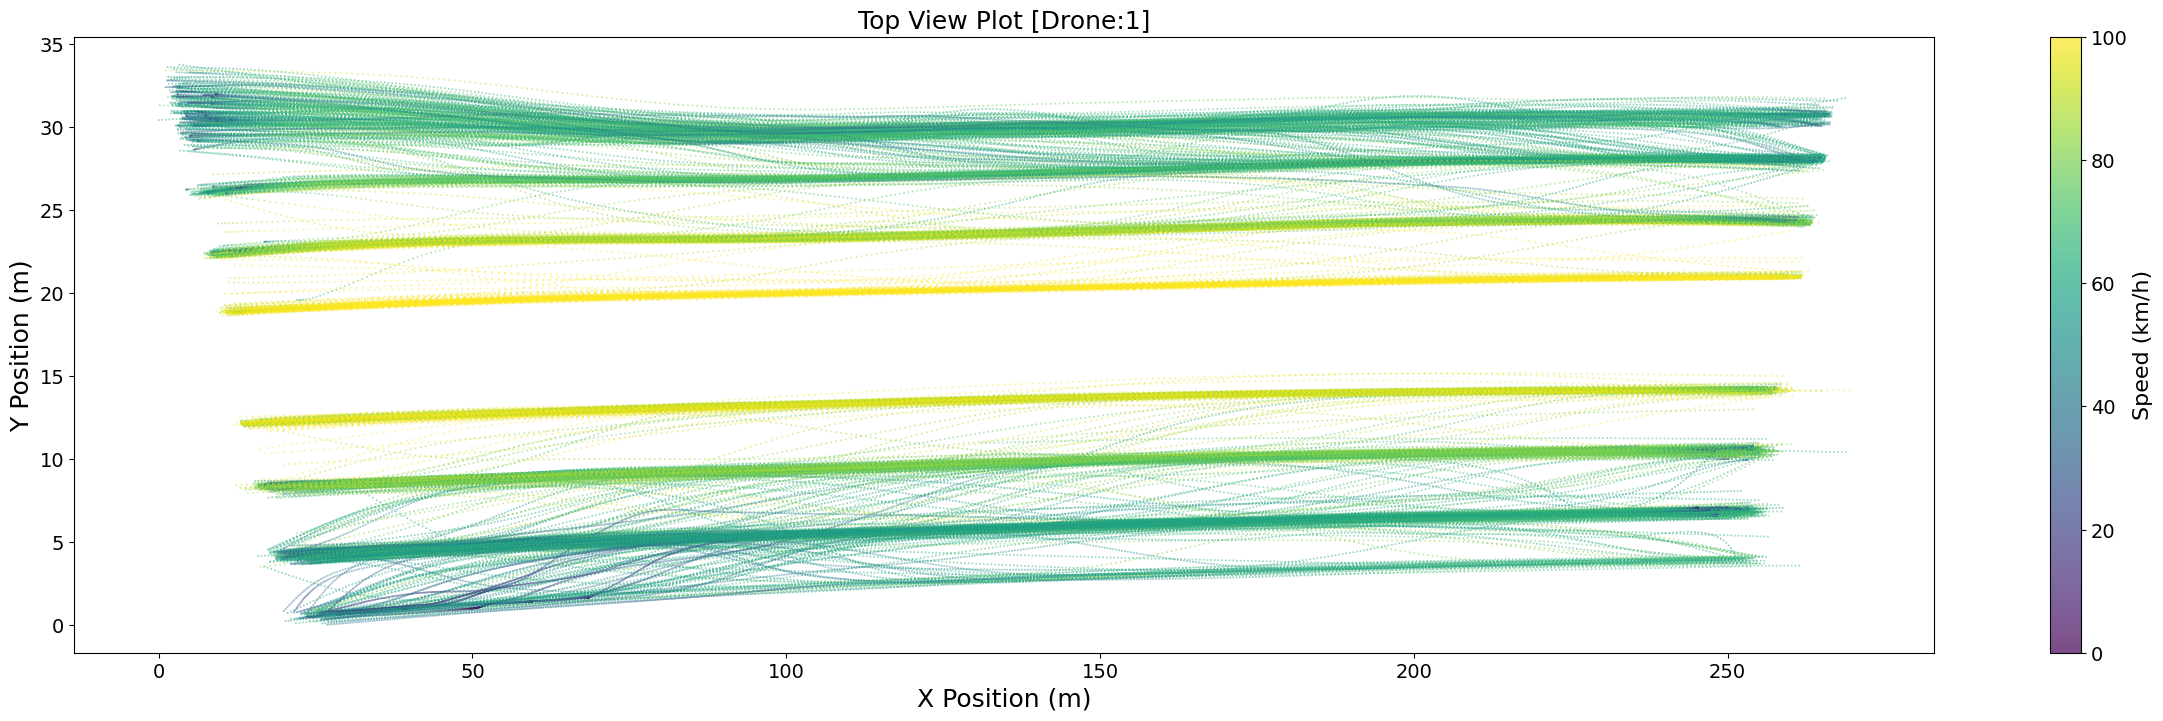

In [21]:

top_view_plot_rotate(data_1_rotate,1,1)

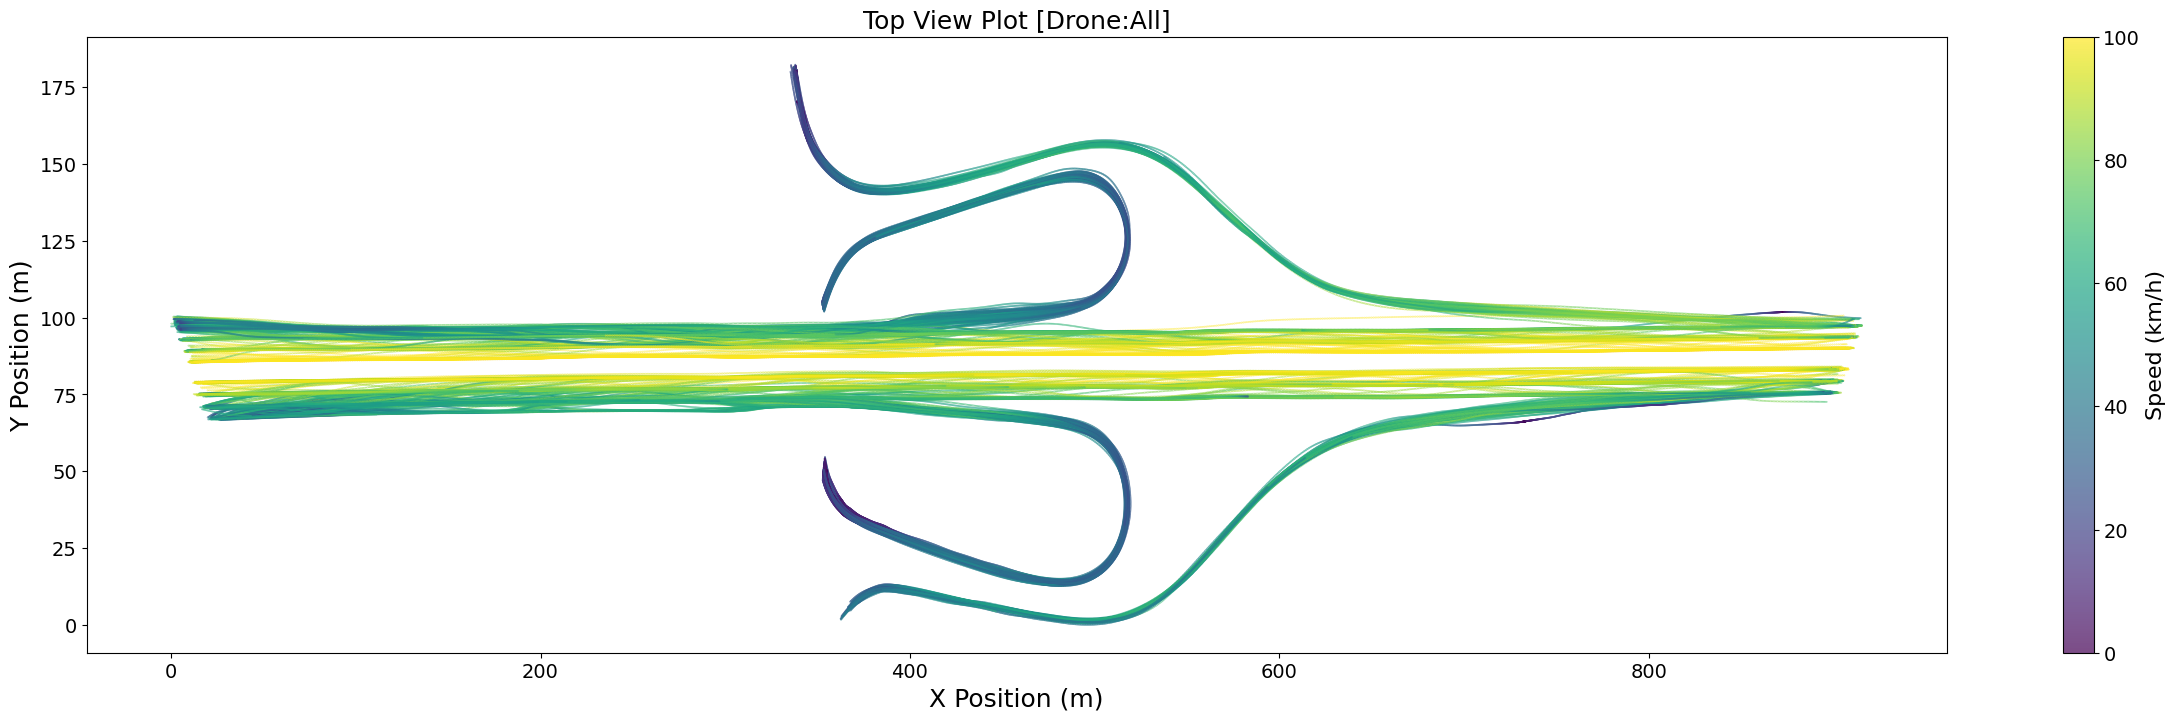

In [22]:
top_view_plot_rotate(data_all_rotate,'All',1)

# IDM implementation using the data

### Leader-Follower(Subject Vehicle) Data Creation

In [ ]:
def data_filter(data, subject_ID):
    sub_data = data[data['Vehicle_ID'] == subject_ID]
    leaders = sub_data['Leader_ID'].unique()

    leaders_data = pd.DataFrame()  # default empty DataFrame

    if -1 in leaders:
        leaders = leaders[leaders != -1]  # remove -1
    if len(leaders) > 0:
        leaders_data = data[data['Vehicle_ID'].isin(leaders)]

    final_data = pd.concat((sub_data, leaders_data))
    return final_data

def check_time_continuity(data, expected_diff=0.033367, tolerance=1e-6):
    time_diffs = data['Time [s]'].diff().dropna()
    # Check if all differences are within the allowed tolerance
    is_continuous = np.all(np.abs(time_diffs - expected_diff) < tolerance)
    return is_continuous


In [63]:
def process_timestamp_group(timestamp, group):
    leader_follower_pairs = []

    # Use Vehicle_ID as index for fast lookup
    group = group.set_index('Vehicle_ID')
    
    for follower_ID, row in group.iterrows():
        leader_ID = row['Leader_ID']
        
        # Skip if no leader
        if leader_ID == -1 or leader_ID not in group.index:
            continue

        f = row  # follower row
        l = group.loc[leader_ID]  # leader row

        # Average dimensions
        avg_width = (f['Vehicle_width [m]'] + l['Vehicle_width [m]']) / 2
        avg_length = (f['Vehicle_length [m]'] + l['Vehicle_length [m]']) / 2

        # Gap calculation
        if f['Lane'] < 4 and l['Lane'] < 4:
            gap_x = (l['x_rot'] - f['x_rot']) - avg_length
        else:
            gap_x = -1 * (l['x_rot'] - f['x_rot']) - avg_length

        gap_y = abs(l['y_rot'] - f['y_rot']) - avg_width

        if gap_x > 0 and gap_y <= 0:
            relative_speed = (f['Speed [km/h]'] - l['Speed [km/h]']) * 5 / 18  # Convert to m/s
            leader_follower_pairs.append({
                'Time [s]': timestamp,
                'Leader': l.name,
                'Follower': f.name,
                'Leader Vehicle Type': l['Vehicle_type'],
                'Follower Vehicle Type': f['Vehicle_type'],
                'Follower x_rotated': f['x_rot'],
                'Follower y_rotated': f['y_rot'],
                'Leader x_rotated': l['x_rot'],
                'Leader y_rotated': l['y_rot'],
                'Leader Speed': l['Speed [km/h]'] * 5 / 18,
                'Follower Speed': f['Speed [km/h]'] * 5 / 18,
                'Leader Lon. Acc.': l['Lon. Acc. [ms-2]'],
                'Leader Lat. Acc.': l['Lat. Acc. [ms-2]'],
                'Follower Lon. Acc.': f['Lon. Acc. [ms-2]'],
                'Follower Lat. Acc.': f['Lat. Acc. [ms-2]'],
                'Relative speed': relative_speed,
                'gap_y[m]': gap_y,
                'gap[m]': gap_x,
                'Lane': f['Lane']
            })

    return leader_follower_pairs

In [128]:
def identify_leader_follower_pairs(data, n_jobs=-1):
    # Group by timestamp and process in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_timestamp_group)(timestamp, group)
        for timestamp, group in tqdm(data.groupby('Time [s]'), desc="Processing timestamps")
    )

    # Flatten nested lists
    lfdata=pd.DataFrame([pair for sublist in results for pair in sublist])
    return lfdata
    if check_time_continuity(lfdata):
        return lfdata
    else:
        return None



In [101]:
class IDM:
    def __init__(self,v0,T,s0,a,b):
        self.v0=v0
        self.T=T
        self.s0=s0
        self.a=a
        self.b=b

        self.speed_limit = 1000
        self.bmax=9
    
    #free acceleration equation
    '''
    @param v: actual speed (m/s)
    @return : free acceleration (m/s**2)
    '''

    
    def calcAccFree(self,v):

        # determine valid local v0

        v0eff = np.maximum(0.01,np.minimum(self.v0,self.speed_limit))

        accFree = self.a*(1-math.pow(v/v0eff,4)) if v<v0eff else self.a*(1-(v/v0eff))

        return  accFree

    # interaction Acceleration equation

    '''
    @param s:     actual gap [m]
    @param v:     actual speed [m/s]
    @param vl:    leading speed [m/s]
    @return:  acceleration [m/s^2]
    '''

    def calcAccInt(self,s,v,vl):

        sstar = self.s0 + np.maximum(0,v*self.T + 0.5*v*(v-vl)/np.sqrt(self.a*self.b))

        accInt = -self.a*math.pow(sstar/np.maximum(s,0.1*self.s0),2)

        
        return np.maximum(-self.bmax,accInt)

    
    # Final longitudinal acceleration equation

    def calcAccLong(self,s,v,vl):
        accLong=np.maximum(-self.bmax,self.calcAccFree(v)+self.calcAccInt(s,v,vl))
       
        return accLong



def sim(v0,T,s0,a,b, data):
    count=0
    GAP_MIN=0.4
    data=data.reset_index()
    dt=0.033367
    #print(f'simulate CF pair with v0={v0},T={T},s0={s0},a={a},b={b}')
    CF=IDM(v0,T,s0,a,b)    # IDM model as defined above
    

    # convert pandas dataframe to arrays since left-assignment faster
    
    #x1=np.empty(len(data), dtype=float)
    v1=np.empty(len(data), dtype=float)
    gap1=np.empty(len(data), dtype=float)
    acc1=np.empty(len(data), dtype=float)

    # export data gaps to numpy array to  limit gap to values >=GAP_VAL
    # !!! by reference, also original data['gap[m]'] affected by mainpul gapData
    
    gapData=data['gap[m]'].to_numpy()
    for i in range(0,len(data)):
        gapData[i]=max(GAP_MIN,gapData[i])
                       
    #print(f'FCdata=',FCdata)
    #print(f'gapData=',gapData)

    # initialisation
    
    v1[0]=data.loc[0,'Follower Speed'] 
    gap1[0]=gapData[0] #max(GAP_MIN,data.loc[0,'gap[m]'])
    acc1[0]=CF.calcAccLong(gap1[0],v1[0],data.loc[0,'Leader Speed']) 

    # simulation
    
    for i in range(1,len(data)):
        #if i<1181:
        if False:
            print(f'\nsim: time step i=',i,' gap1[i-1]=',gap1[i-1],' v1[i-1]=',v1[i-1])

       

        v1[i]=v1[i-1]+acc1[i-1]*dt 
        v_lead=0.5*(data.loc[i-1,'Leader Speed']+data.loc[i,'Leader Speed'])
        gap1[i]=gap1[i-1]+(v_lead-0.5*(v1[i]+v1[i-1]))*dt


        
        # if estimated speed negative, assume a stop and no further decel
        # (before possible gap reset because gap reset is dominating the actions)
        
        if v1[i]<-1e-6:  # then acc1 strictly<0
            v1[i]=0
            gap1[i]=gap1[i-1]+v_lead*dt -(-0.5*v1[i-1]**2/acc1[i-1])

        # reset gap if new leader
        
        if data.loc[i,'Leader']!=data.loc[i-1,'Leader']:
            #v1[i]=data.loc[i,'Follower Speed']  #!! No speed reset!
            gap1[i]=gapData[i] #data.loc[i,'gap[m]']
            #print(f' new leader, i={i}: reset gap1[i]={gap1[i]}, unchanged v={v1[i]}')

         # reset for change in follower gap if new follower
        if data.loc[i,'Follower']!=data.loc[i-1,'Follower']:
            count+=1
            v1[i]=data.loc[i,'Follower Speed']  #!! No speed reset!
            gap1[i]=gapData[i] #data.loc[i,'gap[m]']
            #print(f' new leader, i={i}: reset gap1[i]={gap1[i]}, unchanged v={v1[i]}')

        


        acc1[i]=CF.calcAccLong(gap1[i],v1[i],data.loc[i,'Leader Speed'])

        if False:
        #if i<10:
            print(f'i={i} sLast={gap1[i-1]} vLast={v1[i-1]} vlLast={data.loc[i-1,"lead_vx"]} acc1[i-1]={acc1[i-1]}')

    
    
    data['v1']=v1.tolist()
    data['gap1']=gap1.tolist()
    data['acc1']=acc1.tolist()

    sse= sum((data['gap1']-data['gap[m]'])**2)
    sse1= sum((gapData-gap1)**2)
    #avg_error=sum(abs(data['gap1']-data['gap[m]']))/len(data) Ankit: measure MAD
    avg_error=np.sqrt(sse/len(data))
    #print(f'simulated CF pair with v0={v0},T={T},s0={s0},a={a},b={b}, SSE={sse}, sse1={sse1}')
    #print(f'simulated CF pair {data["subj"].unique()} with v0={v0},T={T},s0={s0},a={a},b={b}, SSE={sse}',count)
    return  [sse,avg_error,data]    



In [108]:
def plot_trajectory_comparison(df_traj):
    plt.figure(figsize=(15, 10))

    # Longitudinal position
    plt.subplot(2, 1, 1)
    plt.plot(df_traj['Time [s]'], df_traj['gap[m]'], label='Real Gap', linewidth=2)
    plt.plot(df_traj['Time [s]'], df_traj['gap1'], '--', label='Predicted Gap', linewidth=2)
    plt.xlabel('Time [s]')
    plt.ylabel('Gap [m]')
    plt.title('Longitudinal Gap')
    plt.legend()

    # Lateral position
    plt.subplot(2, 1, 2)
    plt.plot(df_traj['Time [s]'], df_traj['Follower Speed'], label='Real Speed', linewidth=2)
    plt.plot(df_traj['Time [s]'], df_traj['v1'], '--', label='Simulated Speed', linewidth=2)
    plt.xlabel('Time [s]')
    plt.ylabel('Speed [km/h]')
    plt.title('Longitudinal Speed')
    plt.legend()

    

    plt.tight_layout()
    plt.show()


In [145]:
lf_data=identify_leader_follower_pairs(data_filter(data_all_rotate,450))

Processing timestamps: 100%|██████████| 920/920 [00:00<00:00, 2477.23it/s]


In [146]:
lf_data.head()

,Time [s],Leader,Follower,Leader Vehicle Type,Follower Vehicle Type,Follower x_rotated,Follower y_rotated,Leader x_rotated,Leader y_rotated,Leader Speed,Follower Speed,Leader Lon. Acc.,Leader Lat. Acc.,Follower Lon. Acc.,Follower Lat. Acc.,Relative speed,gap_y[m],gap[m],Lane
0,109.376149,446.0,450.0,Car,Car,-1.802104e+06,4.719999e+06,-1.802134e+06,4.719999e+06,30.916111,30.020306,0.9339,0.0142,-0.3393,-0.0089,-0.895806,-1.773155,25.012010,4
1,109.409516,446.0,450.0,Car,Car,-1.802105e+06,4.719999e+06,-1.802135e+06,4.719999e+06,30.947417,30.018194,0.9415,0.0111,-0.3016,-0.0086,-0.929222,-1.782028,25.038866,4
2,109.442882,446.0,450.0,Car,Car,-1.802106e+06,4.719999e+06,-1.802136e+06,4.719999e+06,30.979000,30.017306,0.9530,0.0080,-0.2422,-0.0091,-0.961694,-1.777473,25.070159,4
3,109.476249,446.0,450.0,Car,Car,-1.802107e+06,4.719999e+06,-1.802137e+06,4.719999e+06,31.010667,30.018278,0.9445,0.0032,-0.1647,-0.0101,-0.992389,-1.772919,25.101452,4
4,109.509616,446.0,450.0,Car,Car,-1.802108e+06,4.719999e+06,-1.802138e+06,4.719999e+06,31.041722,30.021583,0.9173,0.0008,-0.0717,-0.0096,-1.020139,-1.777296,25.137241,4


In [163]:
predicted_data=sim(50,0.66,0.4,0.88,9,lf_data)[2]  #Using Random values of IDM parameters

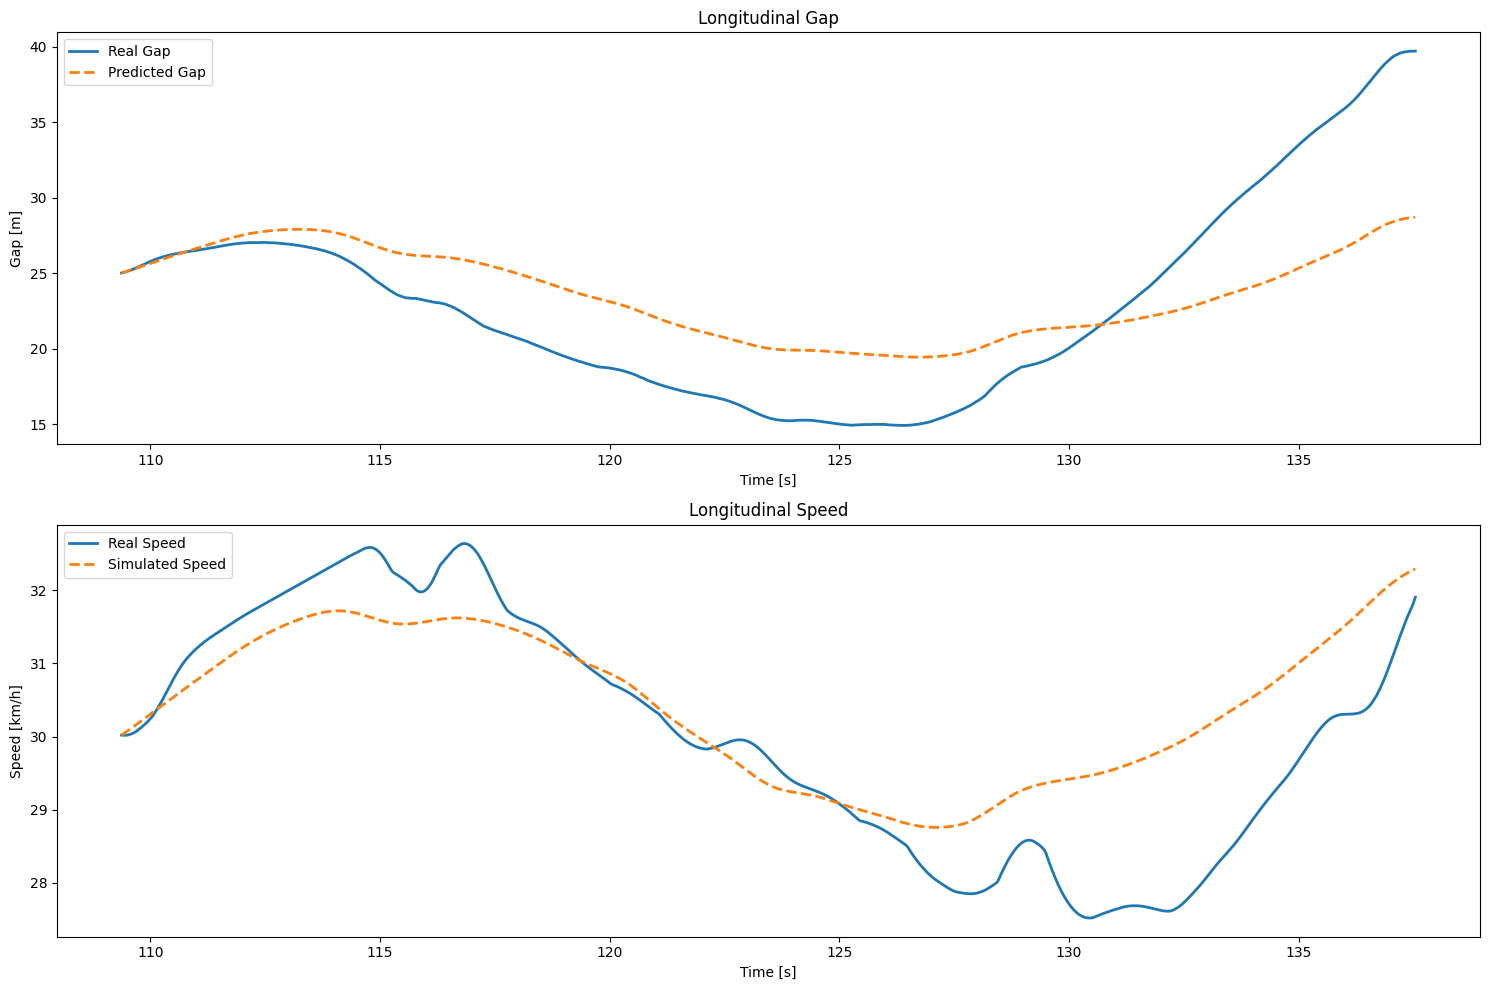

In [164]:
plot_trajectory_comparison(predicted_data)